In [1]:
import cv2
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from glob import glob

from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader, sampler, random_split, Dataset
import torch
import timm
import random

import pandas as pd

In [2]:
DEVICE = torch.device("cuda")
torch.manual_seed(276)
SHAPE = (150,150,3)
IN_CHANNELS = 3
NUM_CLASSES = 6
BATCH_SIZE = 16
WEIGHT_PATH = '/home/annop/extra/hcc-sc/weight/'
CLASS_MAP = {'0':'building', '1':'forests', '2':'glacier', '3':'mountain', '4':'sea', '5':'street'}

In [3]:
def getImageFromDataset(testDataset, idx):
    sampleImage, sampleLabel, path = testDataset.__getitem__(idx)[0], testDataset.__getitem__(idx)[1].numpy(), str(testDataset.__getitem__(idx)[2])
    sampleLabel = int(sampleLabel)
    sampleImage = ((sampleImage.permute(1,2,0).numpy()))
    sampleClassName = sampleLabel
    return sampleImage, sampleClassName, path

In [4]:
def test_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    all_label = []
    all_conf = []
    all_pred = []
    with torch.no_grad():
        for data, labels, _ in tqdm(test_loader):
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            outputs = model(data)
            scores = torch.nn.functional.softmax(outputs, dim=1)
            conf, pred = torch.max(scores,1)

            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

            all_label.append(labels.cpu())
            all_pred.append(pred)
            all_conf.append(conf)

    all_conf = torch.cat(all_conf).cpu().numpy()
    all_label = torch.cat(all_label).cpu().numpy()
    all_pred = torch.cat(all_pred).cpu().numpy()
    return correct, total, all_label, all_pred, all_conf

In [5]:
def showRandomSamples(labels, predicted, conf,dataset, sampleNum=5):
    incorrect_im_path = []
    
    equals = labels == predicted 
    correctIdx = np.where(equals == 1)[0].tolist()
    
    incorrectIdx = np.where(equals == 0)[0].tolist()

    randomCorrectIdx = random.sample(correctIdx, sampleNum)
    randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

    _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

    for imageIdx in range(len(randomCorrectIdx)):
        image, className, path = getImageFromDataset(dataset, randomCorrectIdx[imageIdx])
        sample_conf = conf[randomCorrectIdx[imageIdx]]
        figure[0,imageIdx].imshow(image,cmap='gray')
        className = map_label_name(className)
        figure[0,imageIdx].title.set_text(f'[CORRECT] {str(className)} confidence : {str(sample_conf)}')
  
    for imageIdx in range(len(randomIncorrectIdx)):
        image, className, path = getImageFromDataset(dataset, randomIncorrectIdx[imageIdx])
        incorrect_im_path.append(path)
        figure[1,imageIdx].imshow(image,cmap='gray')
        predictedClassName = predicted[randomIncorrectIdx[imageIdx]]
        predictedClassName = int(predictedClassName)
        sample_conf = conf[randomIncorrectIdx[imageIdx]]
        className = map_label_name(className)
        predictedClassName = map_label_name(predictedClassName)
        figure[1,imageIdx].title.set_text(f'Actual: {str(className)} Predicted: {str(predictedClassName)} Conf : {str(sample_conf)}')
    plt.show()
    return incorrect_im_path

In [6]:
def map_label_name(cat):
    for k,v in CLASS_MAP.items():
            if k == str(cat):
                label = v
    return label

In [7]:
def load_weight(model, backbone, fold):
    weight_path = os.path.join(WEIGHT_PATH, f"{backbone}_fold_{fold}.pth")
    weight = torch.load(weight_path, map_location=DEVICE)
    model.load_state_dict(weight)
    model.eval()
    return model

In [8]:
def plt_im(im_path):
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image, cmap='gray')

In [9]:
class SceneDataset(Dataset):
    def __init__(
            self,
            root_dir = '/home/annop/HCC-sc/',
            lookup_csv = "/home/annop/HCC-sc/lookup.csv",
            is_train = True,
            transform = None
            ):
        if is_train:
            self.im_paths = sorted(glob(root_dir + 'train/*.jpg'))
        elif not is_train:
            self.im_paths = sorted(glob(root_dir + 'test/*.jpg'))
        self.transform = transform
        self.lookup_df = pd.read_csv(lookup_csv)

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, index):
        im_path = self.im_paths[index]
        image = cv2.imread(im_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255.0

        im_name = im_path.split('/')[-1]
        label = self.lookup_df[self.lookup_df['image_name']==im_name]['label'].values[0]
        label = torch.tensor(int(label)).long()

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]
            image = image.float()

        return image, label, im_path


In [10]:
def create_model(backbone):
    model = timm.create_model(backbone, pretrained=True, 
                                         in_chans=IN_CHANNELS, num_classes=NUM_CLASSES)        
    return model

In [11]:
def gen_fold_result(weight_path, test_dataset):
    to_df_dict = {'model':[], 'fold':[], 'accuracy': []}
    weights = glob(weight_path + '*')
    for weight_path in weights:
        print('Load weight and infer : ', weight_path)
        model_name = weight_path.split('/')[-1].split('_fold')[0]
        fold = weight_path.split('/')[-1].split('_')[-1].split('.pth')[0] 
        model = create_model(model_name)
        weight = torch.load(weight_path, map_location=DEVICE)
        model.load_state_dict(weight)
        model.eval()
        model.to(DEVICE)
        
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False, num_workers=8)
        correct, total, all_label, all_pred, all_conf = test_model(test_loader, model)
        accuracy = (correct / total) * 100
        
        to_df_dict['model'].append(model_name)
        to_df_dict['fold'].append(fold)
        to_df_dict['accuracy'].append(accuracy)
    return pd.DataFrame.from_dict(to_df_dict)

        

In [12]:
transform = A.Compose(
            [
                A.Resize(height=150, width=150),
                ToTensorV2(),
            ]
        )

In [13]:
test_dataset = SceneDataset(is_train=False, transform=transform)

In [25]:
fold_result = gen_fold_result('/home/annop/extra/hcc-sc/weight/', test_dataset)

Load weight and infer :  /home/annop/extra/hcc-sc/weight/inception_resnet_v2_fold_3.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/resnet50_fold_3.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/xception_fold_2.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/resnext50_32x4d_fold_2.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/resnet50_fold_2.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/densenet121_fold_3.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/xception_fold_1.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/xception_fold_3.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/densenet121_fold_2.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/resnext50_32x4d_fold_3.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/efficientnetv2_m_fold_1.pth


No pretrained weights exist for this model. Using random initialization.


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/vgg16_fold_2.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/resnext50_32x4d_fold_1.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/densenet121_fold_1.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/efficientnetv2_m_fold_3.pth


No pretrained weights exist for this model. Using random initialization.


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/inception_resnet_v2_fold_2.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/vgg16_fold_3.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/vgg16_fold_1.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/inception_resnet_v2_fold_1.pth


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/efficientnetv2_m_fold_2.pth


No pretrained weights exist for this model. Using random initialization.


  0%|          | 0/214 [00:00<?, ?it/s]

Load weight and infer :  /home/annop/extra/hcc-sc/weight/resnet50_fold_1.pth


  0%|          | 0/214 [00:00<?, ?it/s]

# ModelOps and Fold Summarize

In [26]:
fold_result.sort_values(by='model').set_index(['model','fold'])

accuracy
model               fold           
densenet121         1     91.764361
                    3     91.324736
                    2     91.119578
efficientnetv2_m    1     67.790152
                    3     63.423212
                    2     65.973036
inception_resnet_v2 1     88.716295
                    2     88.423212
                    3     89.390387
resnet50            2     90.504103
                    3     91.295428
                    1     90.973036
resnext50_32x4d     3     91.441970
                    1     90.123095
                    2     90.621336
vgg16               2     91.324736
                    3     91.178195
                    1     90.767878
xception            1     92.262603
                    2     91.969519
                    3     92.731536

In [27]:
fold_result.groupby('model').mean().sort_values(by='accuracy', ascending=False)

,accuracy
model,
xception,92.321219
densenet121,91.402892
vgg16,91.090270
resnet50,90.924189
resnext50_32x4d,90.728800
inception_resnet_v2,88.843298
efficientnetv2_m,65.728800


In [29]:
fold_result[fold_result['model']=='xception'].sort_values(by='accuracy', ascending=False)

,model,fold,accuracy
7,xception,3,92.731536
6,xception,1,92.262603
2,xception,2,91.969519


In [14]:
model = create_model('xception')
model = load_weight(model, 'xception', 3)
model.to(DEVICE)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [15]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False, num_workers=8)
correct, total, all_label, all_pred, all_conf = test_model(test_loader, model)

  0%|          | 0/214 [00:00<?, ?it/s]

# Inference & Evaluation

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       521
           1       0.98      0.99      0.99       548
           2       0.90      0.86      0.88       584
           3       0.87      0.91      0.89       600
           4       0.96      0.95      0.96       565
           5       0.93      0.93      0.93       594

    accuracy                           0.93      3412
   macro avg       0.93      0.93      0.93      3412
weighted avg       0.93      0.93      0.93      3412



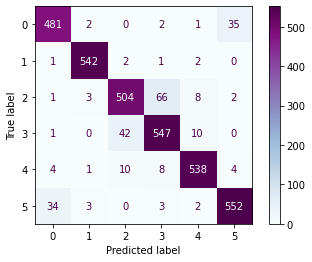

In [16]:
print(classification_report(all_label, all_pred))
confusionMatrix = confusion_matrix(all_label, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)
disp.plot(cmap='BuPu')

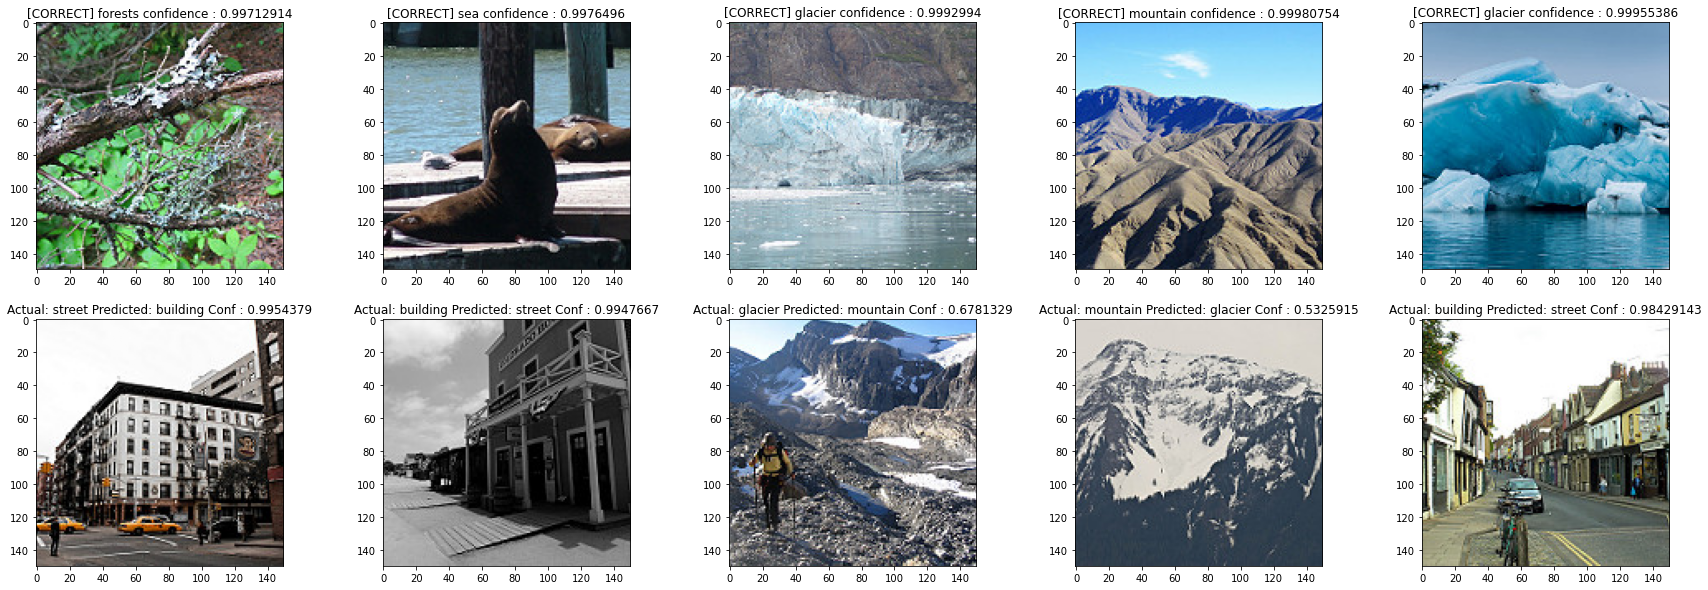

['/home/annop/HCC-sc/test/3054.jpg',
 '/home/annop/HCC-sc/test/20246.jpg',
 '/home/annop/HCC-sc/test/14507.jpg',
 '/home/annop/HCC-sc/test/15235.jpg',
 '/home/annop/HCC-sc/test/3540.jpg']

In [17]:
showRandomSamples(all_label, all_pred, all_conf, test_dataset, sampleNum=5)

# GradCam - XAI Model Decision Intepretation

In [65]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import random

target_layers = [model.block12.rep[-3].conv1]
sample = test_dataset[random.randint(0, len(test_dataset))]
input_tensor = sample[0].unsqueeze(0)

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
_, pred = model(input_tensor.cuda()).max(1)

targets = [ClassifierOutputTarget(sample[1].item())]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]
rgb_img = input_tensor.squeeze(0).permute(1,2,0).numpy()
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'gt: glacier | pred: glacier')

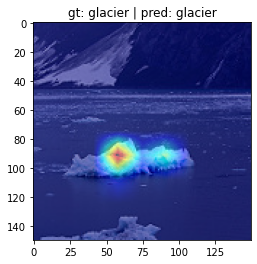

In [66]:
plt.imshow(visualization)
plt.title(f"gt: {CLASS_MAP.get(str(sample[1].item()))} | pred: {CLASS_MAP.get(str(pred.item()))}")